In [1]:
# Standard library imports
import os

# Third party imports
import numpy as np
import pandas as pd
import qpsolvers
import matplotlib.pyplot as plt

In [2]:
path_to_data = 'qpmwp-course/data/'
# N = 24
N = 10
df = pd.read_csv(os.path.join(path_to_data, 'msci_country_indices.csv'),
                    index_col=0,
                    header=0,
                    parse_dates=True,
                    date_format='%d-%m-%Y')
series_id = df.columns[0:N]
X = df[series_id]

X

,AT,AU,BE,CA,CH,DE,DK,ES,FI,FR
Index,,,,,,,,,,
1999-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1999-01-04,0.010057,0.009080,0.042147,0.013070,0.035885,0.052249,0.026198,0.069051,0.052778,0.049229
1999-01-05,0.013661,-0.010048,0.020162,0.021940,0.012016,0.001444,-0.001789,0.026011,0.014154,0.011346
1999-01-06,0.000000,0.015264,-0.000078,0.027640,0.015335,0.036205,0.000432,0.000000,0.000000,0.021537
1999-01-07,0.004104,0.016564,-0.016877,-0.003480,-0.011902,-0.020187,-0.019041,-0.015610,0.028012,-0.013856
...,...,...,...,...,...,...,...,...,...,...
2023-04-12,-0.002488,0.004714,-0.012072,0.001708,0.000017,0.002662,0.012029,0.006452,-0.005646,0.000822
2023-04-13,0.001297,-0.003806,-0.000049,0.004728,0.000913,0.002400,0.012177,0.002304,0.000147,0.011425
2023-04-14,0.009533,0.004829,0.007622,0.001950,0.008387,0.005797,0.020079,0.005836,0.003530,0.004589


In [ ]:
scalefactor = 1  # could be set to 252 (trading days) for annualized returns


# Expected returns

##  This would be wrong:
##  mu = X.mean()

## This is correct:
mu = np.exp(np.log(1 + X).mean(axis=0) * scalefactor) - 1

# Covariance matrix
covmat = X.cov() * scalefactor


mu, covmat

(AT    0.000130
 AU    0.000288
 BE    0.000047
 CA    0.000269
 CH    0.000149
 DE    0.000151
 DK    0.000429
 ES    0.000128
 FI    0.000145
 FR    0.000199
 dtype: float64,
           AT        AU        BE        CA        CH        DE        DK  \
 AT  0.000239  0.000054  0.000125  0.000075  0.000097  0.000138  0.000097   
 AU  0.000054  0.000104  0.000039  0.000030  0.000035  0.000041  0.000041   
 BE  0.000125  0.000039  0.000175  0.000064  0.000104  0.000137  0.000093   
 CA  0.000075  0.000030  0.000064  0.000130  0.000058  0.000087  0.000053   
 CH  0.000097  0.000035  0.000104  0.000058  0.000120  0.000121  0.000086   
 DE  0.000138  0.000041  0.000137  0.000087  0.000121  0.000202  0.000105   
 DK  0.000097  0.000041  0.000093  0.000053  0.000086  0.000105  0.000151   
 ES  0.000150  0.000044  0.000138  0.000081  0.000116  0.000164  0.000100   
 FI  0.000140  0.000050  0.000136  0.000091  0.000126  0.000180  0.000119   
 FR  0.000143  0.000045  0.000142  0.000084  0.000122

In [ ]:
# Lower and upper bounds
lb = np.zeros(covmat.shape[0])
# ub = np.repeat(0.2, N)
ub = np.repeat(1, N)

lb, ub


# Budget constraint
A = np.ones((1, N))
b = np.array(1.0)

A, b


# LInear inequality constraints
G = np.zeros((2, N))
G[0, 0:5] = 1
G[1, 6:10] = 1
# h = np.array([1, 1])
h = np.array([0.5, 0.5])

G, h

(array([[1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.]]),
 array([0.5, 0.5]))

In [ ]:
# Scale the covariance matrix by the risk aversion parameter
risk_aversion = 1
P = covmat * risk_aversion


# Define problem and solve
problem = qpsolvers.Problem(
    P = P.to_numpy(),
    # q = mu.to_numpy(),
    q = mu.to_numpy() * -1,   # don't forget to multiply by -1 since we are minimizing
    G = G,
    h = h,
    A = A,
    b = b,
    lb = lb,
    ub = ub
)

solution = qpsolvers.solve_problem(
    problem = problem,
    solver = 'cvxopt',
    initvals = None,
    verbose = False,
)


# Inspect the solution object
solution
dir(solution)
solution.obj
solution.found
solution.is_optimal
solution.primal_residual
solution.dual_residual
solution.duality_gap

solution.x

array([2.41416724e-06, 4.32691892e-01, 1.24055834e-06, 6.72959491e-02,
       3.53698450e-06, 5.70090858e-06, 4.99997627e-01, 5.16913041e-07,
       5.67618582e-07, 5.55280306e-07])

<Axes: >

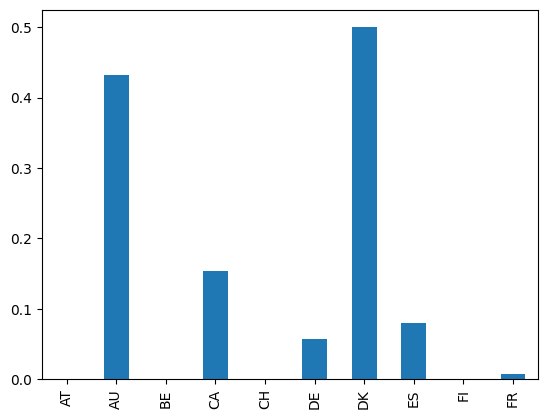

In [ ]:
# Extract weights
weights_mv = {col: float(solution.x[i]) for i, col in enumerate(X.columns)}
weights_mv
weights_mv = pd.Series(weights_mv)
weights_mv.plot(kind='bar')





# --------------------------------------------------------------------------
# Solve for the minimum-variance optimal portfolio
# --------------------------------------------------------------------------

# Define problem and solve
problem = qpsolvers.Problem(
    P = covmat.to_numpy(),
    q = (mu * 0).to_numpy(),
    G = G,
    h = h,
    A = A,
    b = b,
    lb = lb,
    ub = ub
)

solution = qpsolvers.solve_problem(
    problem = problem,
    solver = 'cvxopt',
    initvals = None,
    verbose = False,
)

# Extract weights
weights_minv = {col: float(solution.x[i]) for i, col in enumerate(X.columns)}
weights_minv = pd.Series(weights_minv)

weights_minv.plot(kind='bar')

<Axes: xlabel='Index'>

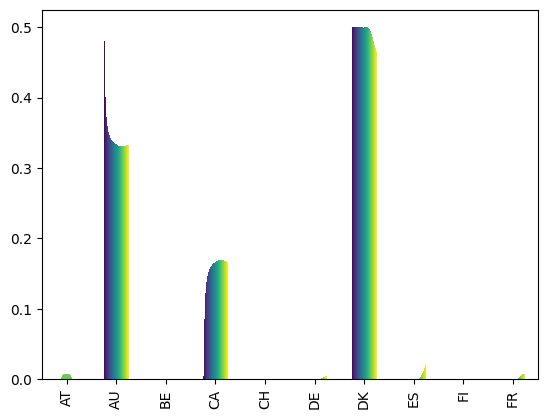

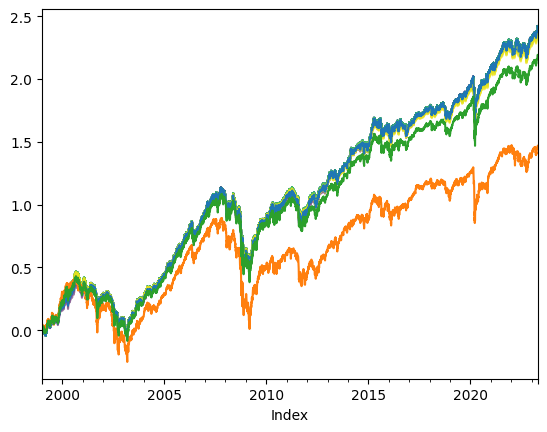

In [ ]:
# --------------------------------------------------------------------------
# Efficient Frontier
# Solve a sequence of mean-variance optimal portfolios
# with varying risk aversion parameters
# --------------------------------------------------------------------------

# Define a grid of risk aversion parameters
risk_aversion_grid = np.linspace(0, 20, 100)

# Prepare an empty dict to store the weights for each risk aversion parameter
weights_dict = {}

# Loop over the grid of risk aversion parameters
for risk_aversion in risk_aversion_grid:

    # Define the problem
    problem = qpsolvers.Problem(
        P = (covmat * risk_aversion).to_numpy(),
        q = mu.to_numpy() * -1,  # don't forget to multiply by -1 since we are minimizing
        G = G,
        h = h,
        A = A,
        b = b,
        lb = lb,
        ub = ub
    )

    # Solve the problem
    solution = qpsolvers.solve_problem(
        problem = problem,
        solver = 'cvxopt',
        initvals = None,
        verbose = False,
    )

    # Extract and store the weights
    weights = {col: float(solution.x[i]) for i, col in enumerate(X.columns)}
    weights_dict[risk_aversion] = pd.Series(weights)
    
# Convert the dict to a DataFrame
weights_df = pd.DataFrame(weights_dict).T
weights_df.index.name = 'risk_aversion'

weights_df
weights_df.T.plot(legend=False, kind='bar', cmap='viridis')



# Plot the efficient frontier

portf_vola = np.diag(weights_df @ covmat @ weights_df.T)
portf_return = weights_df @ mu

plt.scatter(portf_vola, portf_return, c=portf_return / portf_vola, cmap='viridis')



# Plot the historical returns of the portfolios on the efficient frontier

sim = X @ weights_df.T

np.log((1 + sim).cumprod()).plot(legend=False, alpha=0.2, cmap='viridis')

# Add the mean-variance optimal portfolio
np.log((1 + X @ weights_mv).cumprod()).plot(label='Mean-Variance Portfolio')

# Add the equally weighted portfolio
np.log((1 + X.mean(axis=1)).cumprod()).plot(label='Equally Weighted Portfolio')

# Add the minimum-variance portfolio
np.log((1 + X @ weights_minv).cumprod()).plot(label='Minimum-Variance Portfolio')

<Axes: xlabel='Index'>

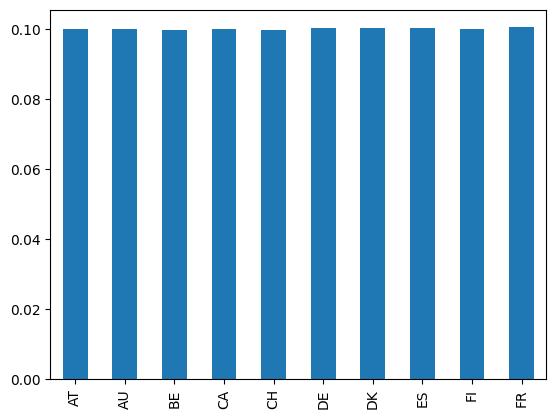

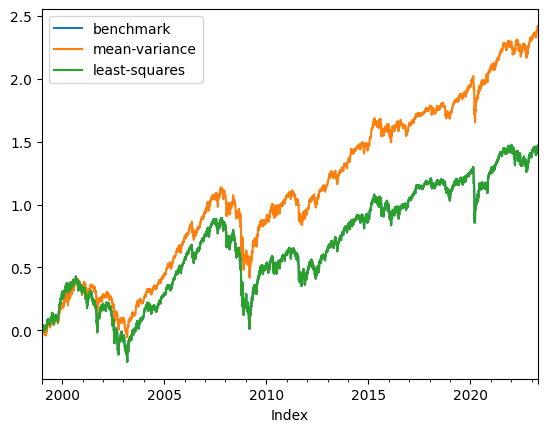

In [ ]:
# # Load msci world index return series
# y = pd.read_csv(f'{path_to_data}NDDLWI.csv',
#                 index_col=0,
#                 header=0,
#                 parse_dates=True,
#                 date_format='%d-%m-%Y')

# Create an equally weighted benchmark series
y = X.mean(axis=1)
y


# Coefficients of the least squares problem

P = 2 * (X.T @ X)
q = -2 * X.T @ y
constant = y.T @ y

# Define problem and solve
problem = qpsolvers.Problem(
    P = P.to_numpy(),
    q = q.to_numpy(),
    G = G,
    h = h,
    A = A,
    b = b,
    lb = lb,
    ub = ub,
)

solution = qpsolvers.solve_problem(
    problem = problem,
    solver = 'cvxopt',
    initvals = None,
    verbose = False,
)

# Extract weights
weights_ls = pd.Series(solution.x, X.columns)
weights_ls.plot(kind='bar')



# Inspect portfolio simulations

sim_mv = (X @ weights_mv).rename('Mean-Variance Portfolio')
sim_ls = (X @ weights_ls).rename('Min Tracking Error Portfolio (by Least Squares)')

sim = pd.concat({
    'benchmark': y,
    'mean-variance': sim_mv,
    'least-squares': sim_ls,
}, axis=1).dropna()
sim

np.log((1 + sim).cumprod()).plot()